# Chapter 6 - Linear Model Selection and Regularization

### [Lab 1: Subset Selection Methods](#lab1)
- [Lab 6.5.1 Best Subset Selection](#lab-6.5.1)
- [Lab 6.5.2 Forward and Backward Stepwise Selection](#lab-6.5.2)
- [Lab 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation](#lab-6.5.3)

### [Lab 2: Ridge Regression and the Lasso](#lab2)
- [Lab 6.6.1 Ridge Regression](#lab-6.6.1)
- [Lab 6.6.2 The Lasso](#lab-6.6.2)

### [Lab 3: PCR and PLS Regression](#lab3)
- [Lab 6.7.1 Principal Components Regression](#lab-6.7.1)
- [Lab 6.7.2 Partial Least Squares](#lab-6.7.2)

### Imports and Configurations

In [1]:
# Standard libraries
from itertools import combinations

# Use rpy2 for loading R datasets
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import data as rdata
from rpy2.robjects import pandas2ri

# Math and data processing
import numpy as np
import scipy as sp
import pandas as pd

# StatsModels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error

# Visulization
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.style.use('ggplot')

<a id='lab1'></a>

## Lab 1: Subset Selection Methods

<a id='lab-6.5.1'></a>

### 6.5.1 Best Subset Selection

In [2]:
# Hitters dataset is in R ISLR package
islr = importr('ISLR')
hitters_rdf = rdata(islr).fetch('Hitters')['Hitters']
hitters = pandas2ri.ri2py(hitters_rdf)
display(hitters.head(5))

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
print(hitters.info())

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, -Andy Allanson to -Willie Wilson
Data columns (total 20 columns):
AtBat        322 non-null int32
Hits         322 non-null int32
HmRun        322 non-null int32
Runs         322 non-null int32
RBI          322 non-null int32
Walks        322 non-null int32
Years        322 non-null int32
CAtBat       322 non-null int32
CHits        322 non-null int32
CHmRun       322 non-null int32
CRuns        322 non-null int32
CRBI         322 non-null int32
CWalks       322 non-null int32
League       322 non-null object
Division     322 non-null object
PutOuts      322 non-null int32
Assists      322 non-null int32
Errors       322 non-null int32
Salary       263 non-null float64
NewLeague    322 non-null object
dtypes: float64(1), int32(16), object(3)
memory usage: 32.7+ KB
None


In [4]:
print(hitters.Salary.isnull().sum())

59


In [5]:
hitters.dropna(axis=0, inplace=True)

In [6]:
print(hitters.shape)
print(hitters.Salary.isnull().sum())

(263, 20)
0


In [7]:
# Score function to produce linear regression fitting and RSS for a feature set
def score_rss(data, feature_set, endog_name):
    """
    Regress score function based on RSS, residual sum of squares.
    """
    # Have to use sm formula interface to avoid manually generate dummies
    reg = smf.ols(endog_name + ' ~ ' + '+'.join(feature_set), data).fit()
    rss = reg.mse_resid * reg.df_resid
    return reg, (-1) * rss

# For a given number of features, select the best combination by score function
def select_k_best(data, k, endog_name, score_function):
    """
    Select the best k features out of all the possible combinations.
    Different than sklearn.feature_selection.SelectKBest.

    data: data frame.
    k: int.
    endog_name: response name.
    score_function: a callable with parameters X, y, feature_set
                    returns: an iterable of (model, score).
    """
    features = data.columns.drop(endog_name)

    # Iterate over all feature combinations and compute scores
    models = []
    scores = []
    for feature_subset in combinations(features, k):
        model, score = score_function(data, feature_subset, endog_name)
        models.append(model)
        scores.append(score)

    # Return the best model with the highest score
    return models[scores.index(max(scores))]

In [8]:
# Define features and response
response = 'Salary'
features = hitters.columns.drop([response])

# Find the best models with 1 to p features
print("\nSearch the best k features for k = 1 to 8, based on RSS.\nTaking long time...\n")
best_models = []
for k in range(1, 8+1):
    best_model = select_k_best(hitters, k, response, score_rss)
    best_models.append(best_model)
    best_features = best_model.model.exog_names
    best_features.remove('Intercept')
    print("Best {} features: {}".format(k, best_features))


Search the best k features for k = 1 to 8, based on RSS.
Taking long time...

Best 1 features: ['CRBI']
Best 2 features: ['Hits', 'CRBI']
Best 3 features: ['Hits', 'CRBI', 'PutOuts']
Best 4 features: ['Division[T.W]', 'Hits', 'CRBI', 'PutOuts']
Best 5 features: ['Division[T.W]', 'AtBat', 'Hits', 'CRBI', 'PutOuts']
Best 6 features: ['Division[T.W]', 'AtBat', 'Hits', 'Walks', 'CRBI', 'PutOuts']
Best 7 features: ['Division[T.W]', 'Hits', 'Walks', 'CAtBat', 'CHits', 'CHmRun', 'PutOuts']
Best 8 features: ['Division[T.W]', 'AtBat', 'Hits', 'Walks', 'CHmRun', 'CRuns', 'CWalks', 'PutOuts']


<a id='lab-6.5.2'></a>

### Lab 6.5.2 Forward and Backward Stepwise Selection

In [9]:
# Forward stepwise selection
def forward_select(data, endog_name, score_function):
    """
    Select features by forward stepwise selection algorithm.

    data: data frame.
    endog_name: response name.
    score_function: a callable with parameters X, y, feature_set
                    returns: an iterable of (model, score).
    """
    features = data.columns.drop(endog_name)
    p = len(features)

    # Loop number of features from 1 to p
    selected_features = []  # start from null model
    for j in range(1, p+1):
        feature_candidates = [xj for xj in features if xj not in selected_features]
        models = []
        scores = []
        # Loop over remaining features at the j-th step
        for xj in feature_candidates:
            feature_subset = selected_features + [xj]
            model, score = score_function(data, feature_subset, endog_name)
            models.append(model)
            scores.append(score)

        # Select the best feature at the j-th step
        best_feature = feature_candidates[scores.index(max(scores))]
        selected_features += [best_feature]
        print(" Best {} features: {}".format(j, selected_features))

In [10]:
# Define features and response
response = 'Salary'
features = hitters.columns.drop([response])

# Run forward stepwise selection on Hitters
print("\nForward stepwise select features based on RSS:\n")
forward_select(hitters, response, score_rss)


Forward stepwise select features based on RSS:

 Best 1 features: ['CRBI']
 Best 2 features: ['CRBI', 'Hits']
 Best 3 features: ['CRBI', 'Hits', 'PutOuts']
 Best 4 features: ['CRBI', 'Hits', 'PutOuts', 'Division']
 Best 5 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat']
 Best 6 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks']
 Best 7 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks']
 Best 8 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns']
 Best 9 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat']
 Best 10 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists']
 Best 11 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League']
 Best 12 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assis

In [11]:
# Backward stepwise selection
def backward_select(data, endog_name, score_function):
    """
    Select features by backward stepwise selection algorithm.

    data: data frame.
    endog_name: response name.
    score_function: a callable with parameters X, y, feature_set
                    returns: an iterable of (model, score).
    """
    features = list(data.columns.drop(endog_name))
    p = len(features)

    # Loop number of features from 1 to p
    selected_features = features.copy()  # start from all the features
    for j in range(p, 0, -1):
        print("Best {} features: {}".format(j, selected_features))
        if j==1: break
        feature_candidates = list(combinations(selected_features, j-1))
        models = []
        scores = []

        # Loop over feature candidates at the j-th step
        for feature_subset in feature_candidates:
            model, score = score_function(data, feature_subset, endog_name)
            models.append(model)
            scores.append(score)

        # Select the best feature at the j-th step
        selected_features = list(feature_candidates[scores.index(max(scores))])

In [12]:
# Define features and response
response = 'Salary'
features = hitters.columns.drop([response])

# Run backward stepwise selection on Hitters
print("\nBackward stepwise select features based on RSS:\n")
backward_select(hitters, response, score_rss)


Backward stepwise select features based on RSS:

Best 19 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague']
Best 18 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague']
Best 17 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague']
Best 16 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors']
Best 15 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors']
Best 14 features: ['AtBat', 'Hits', 'HmRun', 

<a id='lab-6.5.3'></a>

### Lab 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

#### Forward Stepwise Selection using the Validation Set Approach

In [13]:
# Score function and forward select function
def score_rss_valset(data_train, data_test, feature_set, endog_name):
    """
    Regress score function based on RSS, residual sum of squares.
    """
    # Have to use sm formula interface to avoid manually generate dummies
    reg = smf.ols(endog_name + ' ~ ' + '+'.join(feature_set), data_train).fit()
    y_pred = reg.predict(data_test[feature_set])
    y_test = data_test[endog_name].values
    rss = ((y_pred - y_test) ** 2).sum()
    return reg, (-1) * rss

def forward_select_valset(data_train, data_test, endog_name, score_function):
    """
    Select features by forward stepwise selection algorithm.

    data: data frame.
    endog_name: response name.
    score_function: a callable with parameters X, y, feature_set
                    returns: an iterable of (model, score).
    """
    features = data_train.columns.drop(endog_name)
    p = len(features)
    high_scores = []
    best_features = []

    # Loop number of features from 1 to p
    selected_features = []  # start from null model
    for j in range(1, p+1):
        feature_candidates = [xj for xj in features if xj not in selected_features]
        models = []
        scores = []
        # Loop over remaining features at the j-th step
        for xj in feature_candidates:
            feature_subset = selected_features + [xj]
            model, score = score_function(data_train, data_test, feature_subset, endog_name)
            models.append(model)
            scores.append(score)

        # Select the best feature at the j-th step
        highest_score = max(scores)
        high_scores.append(highest_score)
        best_feature = feature_candidates[scores.index(highest_score)]
        selected_features += [best_feature]
        best_features.append(selected_features)

    scores_df = pd.DataFrame(high_scores, index=range(1,p+1), columns=[''])
    scores_df.index.name = '# of x_j'

    best_score = max(high_scores)
    best_j = high_scores.index(best_score) + 1
    return scores_df, best_j, best_score, best_features

In [14]:
# Train-test split. Test set size is random with prob=0.5, as in the book.
np.random.seed(seed=51)
train_mask = np.random.choice([True, False], size = hitters.shape[0], replace = True)
test_mask = np.invert(train_mask)
print("Train set size = ", train_mask.sum())
print("Test set size = ", test_mask.sum())

Train set size =  142
Test set size =  121


Now run forward stepwise selection instead of BSS as in the book to speed up.

In [15]:
# Define features and response
response = 'Salary'
features = hitters.columns.drop([response])

# Run forward stepwise selection on Hitters
print("\nForward stepwise select features on training set, based on RSS. \n")
scores_valset, best_j_valset, best_score, best_features_valset = forward_select_valset(hitters[train_mask], hitters[test_mask], response, score_rss_valset)
print("Mean RSS over numbers of features:")
mean_rss_valset = scores_valset * (-1)
display(mean_rss_valset)
print("\nThe best model is the one having {} features:\n{}".format(best_j_valset, best_features_valset[best_j_valset-1]))


Forward stepwise select features on training set, based on RSS. 

Mean RSS over numbers of features:


,
# of x_j,
1,2.076650e+07
2,1.714363e+07
3,1.617621e+07
4,1.588872e+07
5,1.562742e+07
6,1.508433e+07
7,1.478177e+07
8,1.467281e+07
9,1.452479e+07



The best model is the one having 10 features:
['CRBI', 'Hits', 'Division', 'Years', 'AtBat', 'Walks', 'PutOuts', 'CWalks', 'CRuns', 'RBI', 'Errors', 'Assists', 'HmRun', 'Runs', 'NewLeague', 'League', 'CHmRun', 'CAtBat', 'CHits']


**Finally perform best subset selection on the full data set, and select the best 10-variable model.**

In [16]:
# Run forward stepwise selection on Hitters full date set
print("\nForward stepwise select features on full data set, based on RSS. \n")
_, _, _, best_features_full = forward_select_valset(hitters, hitters, response, score_rss_valset)
print("The best {} features are:\n{}".format(best_j_valset, best_features_full[best_j_valset-1]))


Forward stepwise select features on full data set, based on RSS. 

The best 10 features are:
['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League', 'Runs', 'Errors', 'HmRun', 'CHits', 'RBI', 'NewLeague', 'Years', 'CHmRun']


#### Model Selection using Cross-Validation

In [17]:
# 10-fold CV splits
kf = KFold(10, random_state=55)
# Forward stepwise selection on each split
scores_cv_list = []
for train_index, test_index in kf.split(hitters):
    scores_df, _, _, _ = forward_select_valset(hitters.iloc[train_index], hitters.iloc[test_mask], response, score_rss_valset)
    scores_cv_list.append(scores_df)
# Combine the scores of 10 folds
scores_cv = pd.concat(scores_cv_list, axis=1)
scores_cv.columns = range(1, 11)
scores_cv.columns.name = 'K-Fold'

In [18]:
# Compute mean RSS of 10 folds for each j = 1..p
mean_rss_cv = scores_cv.mean(axis=1) * (-1)
print(mean_rss_cv)

# of x_j
1     1.988162e+07
2     1.469190e+07
3     1.247908e+07
4     1.182492e+07
5     1.148818e+07
6     1.094343e+07
7     1.082744e+07
8     1.081981e+07
9     1.079096e+07
10    1.076345e+07
11    1.058229e+07
12    1.048883e+07
13    1.043509e+07
14    1.035223e+07
15    1.029475e+07
16    1.021250e+07
17    1.019581e+07
18    1.021123e+07
19    1.029496e+07
dtype: float64


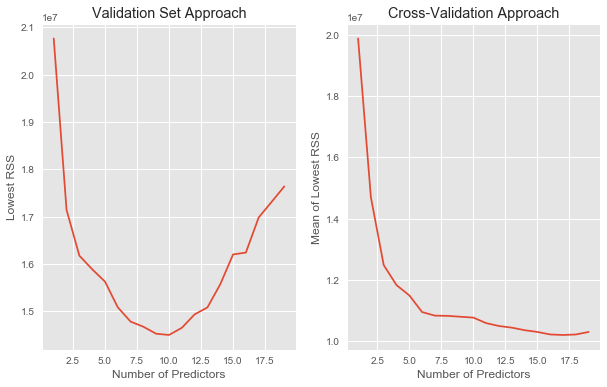

In [38]:
# Plots to compare validation set and cross-validation
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax1 = plt.subplot(121)
plt.plot(range(1, len(features)+1), mean_rss_valset)
plt.title('Validation Set Approach')
plt.xlabel('Number of Predictors')
plt.ylabel('Lowest RSS')
ax2 = plt.subplot(122)
plt.plot(range(1, len(features)+1), mean_rss_cv)
plt.title('Cross-Validation Approach')
plt.xlabel('Number of Predictors')
plt.ylabel('Mean of Lowest RSS')
plt.show()

<a id='lab2'></a>

## Lab 2: Ridge Regression and the Lasso

<a id='lab-6.6.1'></a>

### Lab 6.6.1 Ridge Regression

In [39]:
# Generate dummy variables for qualitative variables
qual_vars = ['League', 'Division', 'NewLeague']
hitters_dummies = pd.get_dummies(hitters[qual_vars])
hitters_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB


In [40]:
# Define X, y features and reponse data for scikit-learn
dummy_vars = ['League_N', 'Division_W', 'NewLeague_N']
response = 'Salary'
y = hitters[response]
# Drop response and qualitative variables, and combine with dummy data frame
X = pd.concat([hitters.drop(qual_vars + [response], axis=1), hitters_dummies[dummy_vars]], axis=1)
features = hitters.columns.drop([response])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null int32
Hits           263 non-null int32
HmRun          263 non-null int32
Runs           263 non-null int32
RBI            263 non-null int32
Walks          263 non-null int32
Years          263 non-null int32
CAtBat         263 non-null int32
CHits          263 non-null int32
CHmRun         263 non-null int32
CRuns          263 non-null int32
CRBI           263 non-null int32
CWalks         263 non-null int32
PutOuts        263 non-null int32
Assists        263 non-null int32
Errors         263 non-null int32
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: int32(16), uint8(3)
memory usage: 19.3+ KB


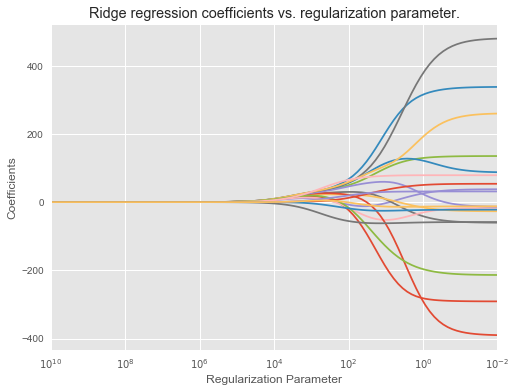

In [41]:
# Ridge regression on full dataset, over 100 alphas from 10 to -2
alphas = 10**np.linspace(10,-2,100)
ridge = Ridge()
coefs = []
for alpha in alphas:
    ridge.set_params(alpha=alpha*0.5)  # alpha/2 to align with R
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)
# Plot
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlim(1e10, 1e-2)  # reverse axis
plt.xlabel('Regularization Parameter')
plt.ylabel('Coefficients')
plt.title('Ridge regression coefficients vs. regularization parameter.')
plt.show()

In [42]:
# Split Hitters data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

**Fit on training set with alpha = 4**

In [43]:
ridge_a4 = Ridge(alpha=4, normalize=True)
ridge_a4.fit(X_train, y_train)
y_pred_a4 = ridge_a4.predict(X_test)
print('\nRidge regression coefficients:\n', pd.Series(ridge_a4.coef_, index=features))
print('\nMSE = ', mean_squared_error(y_test, y_pred_a4))  


Ridge regression coefficients:
 AtBat         0.098658
Hits          0.446094
HmRun         1.412107
Runs          0.660773
RBI           0.843403
Walks         1.008473
Years         2.779882
CAtBat        0.008244
CHits         0.034149
CHmRun        0.268634
CRuns         0.070407
CRBI          0.070060
CWalks        0.082795
League        0.104747
Division     -0.003739
PutOuts       0.268363
Assists       4.241051
Errors      -30.768885
NewLeague     4.123474
dtype: float64

MSE =  106216.52238


**Fit on training set with alpha = 10<sup>10</sup>**

In [44]:
ridge_a1e10 = Ridge(alpha=10**10, normalize=True)
ridge_a1e10.fit(X_train, y_train)
y_pred_a1e10 = ridge_a1e10.predict(X_test)
print('\nRidge regression coefficients:\n', pd.Series(ridge_a1e10.coef_, index=features))
print('\nMSE = ', mean_squared_error(y_test, y_pred_a1e10))  


Ridge regression coefficients:
 AtBat        1.317464e-10
Hits         4.647486e-10
HmRun        2.079865e-09
Runs         7.726175e-10
RBI          9.390640e-10
Walks        9.769219e-10
Years        3.961442e-09
CAtBat       1.060533e-11
CHits        3.993605e-11
CHmRun       2.959428e-10
CRuns        8.245247e-11
CRBI         7.795451e-11
CWalks       9.894387e-11
League       7.268991e-11
Division    -2.615885e-12
PutOuts      2.084514e-10
Assists     -2.501281e-09
Errors      -1.549951e-08
NewLeague   -2.023196e-09
dtype: float64

MSE =  172862.235804


**Ridge regularization with cross-validation**

In [45]:
# Ridge regularization with cross-validation
ridgecv = RidgeCV(alphas=alphas*0.5, scoring='neg_mean_squared_error', normalize=True)
ridgecv.fit(X_train, y_train)
print("The best ridge regularization Alpha = ", ridgecv.alpha_)
ridge_cv = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge_cv.fit(X_train, y_train)
mse = mean_squared_error(y_test, ridge_cv.predict(X_test))
print("MSE = ", mse)

The best ridge regularization Alpha =  0.574878497699
MSE =  99825.6489629


**Ridge regression on full data set with CV-optimized alpha**

In [46]:
ridge_cv.fit(X, y)
print(pd.Series(ridge_cv.coef_, index=features))

AtBat         0.055838
Hits          0.934879
HmRun         0.369048
Runs          1.092480
RBI           0.878259
Walks         1.717770
Years         0.783515
CAtBat        0.011318
CHits         0.061101
CHmRun        0.428333
CRuns         0.121418
CRBI          0.129351
CWalks        0.041990
League        0.179957
Division      0.035737
PutOuts      -1.597699
Assists      24.774519
Errors      -85.948661
NewLeague     8.336918
dtype: float64


**As expected, none of the coefficients are exactly zero - ridge regression does not perform variable selection!**

<a id='lab-6.6.2'></a>

### Lab 6.6.2 The Lasso

**Lasso regression on training set, over 100 alphas from 10 to -2.**

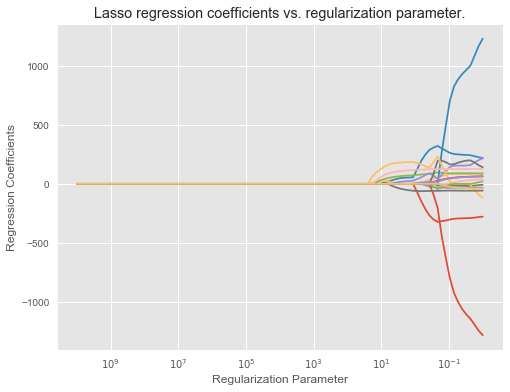

In [47]:
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []
for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('Regularization Parameter')
plt.ylabel('Regression Coefficients')
plt.title('Lasso regression coefficients vs. regularization parameter.')
plt.show()

**Lasso regularization with cross-validation**

In [48]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)
print("The best Lasso regularization Alpha = ", ridgecv.alpha_)
lasso_cv = Lasso(max_iter=10000, normalize=True, alpha=lassocv.alpha_)
lasso_cv.fit(X_train, y_train)
mse = mean_squared_error(y_test, lasso_cv.predict(X_test))
print("MSE = ", mse)

The best Lasso regularization Alpha =  0.574878497699
MSE =  104960.658539


In [49]:
pd.Series(lasso_cv.coef_, index=features)

AtBat         0.000000
Hits          1.082446
HmRun         0.000000
Runs          0.000000
RBI           0.000000
Walks         2.906388
Years         0.000000
CAtBat        0.000000
CHits         0.000000
CHmRun        0.219367
CRuns         0.000000
CRBI          0.513975
CWalks        0.000000
League        0.368401
Division     -0.000000
PutOuts      -0.000000
Assists       0.000000
Errors      -89.064338
NewLeague     0.000000
dtype: float64

**Some coefficients are set to exact 0 by Lasso.**

<a id='lab3'></a>

## Lab 3: PCR and PLS Regression

<a id='lab-6.7.1'></a>

### Lab 6.7.1 Principal Components Regression

In [50]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))
print("The sahpe of loading matrix:", pca.components_.shape)
print("\nHead of loading matrix:")
display(pd.DataFrame(pca.components_.T).loc[:4,:5])

The sahpe of loading matrix: (19, 19)

Head of loading matrix:


,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


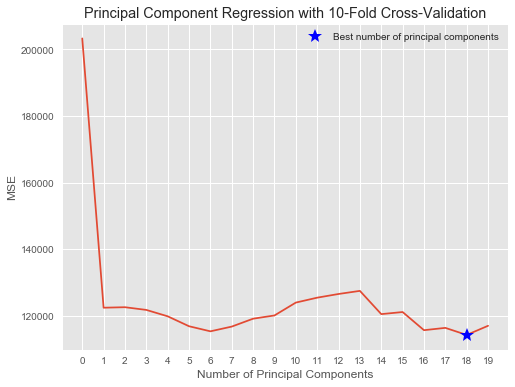

In [51]:
# PCR with number of PCs from 0 to 19, with 10-fold CV
# For 0 PC case, regression on intercept only.
kf = KFold(n_splits=10, shuffle=True, random_state=1)
regr = LinearRegression()
mse = []
for n_pc in range(0, pca.n_components_ + 1):
    if n_pc == 0:
        X_regr = np.ones((len(y),1))
    else:
        X_regr = X_reduced[:, :n_pc]
    scores = cross_val_score(regr, X_regr, y, cv=kf, scoring='neg_mean_squared_error')
    mse.append(scores.mean() * (-1))

# Find the n_pc with lowest MSE, or highest CV score
min_mse = min(mse)
min_mse_idx = mse.index(min_mse)    
    
# Plot MSE vs. number of PCs
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(mse)
plt.xticks(range(20), range(20))
min_mse_marker, = plt.plot(min_mse_idx, min_mse, 'b*', markersize=15)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('Principal Component Regression with 10-Fold Cross-Validation')
plt.legend([min_mse_marker], ['Best number of principal components'])
plt.show()

From the plot we also see that the cross-validation error is roughly the same when only one component is included in the model. This suggests that a model that uses just a small number of components might suffice.

In [52]:
evr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print("Explained Variance Ratio:")
display(pd.Series([str(p) + ' %' for p in evr]))


Explained Variance Ratio:


0     38.31 %
1     60.15 %
2     70.84 %
3     79.03 %
4     84.29 %
5     88.63 %
6     92.26 %
7     94.96 %
8     96.28 %
9     97.25 %
10    97.97 %
11    98.64 %
12    99.14 %
13    99.46 %
14    99.73 %
15    99.88 %
16    99.95 %
17    99.98 %
18    99.99 %
dtype: object

PCR on training data and evaluate its test set performance.

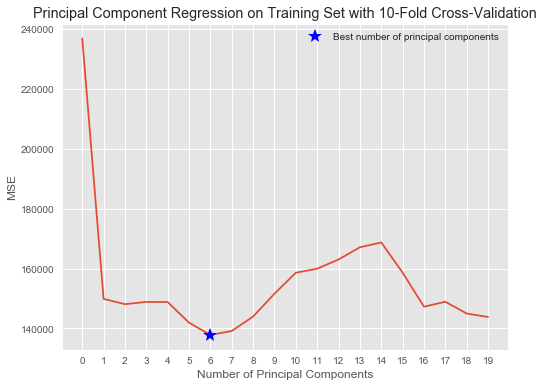

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
X_train_reduced = pca.fit_transform(scale(X_train))

# PCR on training set with number of PCs from 0 to 19, with 10-fold CV
# For 0 PC case, regression on intercept only.
kf = KFold(n_splits=10, shuffle=True, random_state=1)
regr = LinearRegression()
mse = []
for n_pc in range(0, pca.n_components_ + 1):
    if n_pc == 0:
        X_regr = np.ones((len(y_train),1))
    else:
        X_regr = X_train_reduced[:, :n_pc]
    scores = cross_val_score(regr, X_regr, y_train, cv=kf, scoring='neg_mean_squared_error')
    mse.append(scores.mean() * (-1))

# Find the n_pc with lowest MSE, or highest CV score
min_mse = min(mse)
min_mse_idx = mse.index(min_mse)    
    
# Plot MSE vs. number of PCs
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(mse)
plt.xticks(range(20), range(20))
min_mse_marker, = plt.plot(min_mse_idx, min_mse, 'b*', markersize=15)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('Principal Component Regression on Training Set with 10-Fold Cross-Validation')
plt.legend([min_mse_marker], ['Best number of principal components'])
plt.show()

The lowest cross-validation error occurs when 6 components are used. Next perform PCR on the test data and compute the test MSE.

In [54]:
X_test_reduced = pca.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_train_reduced[:,:7], y_train)

# Prediction with test data
y_pred = regr.predict(X_test_reduced)
print("Test set MSE = ", mean_squared_error(y_test, y_pred))

Test set MSE =  111994.422736


<a id='lab-6.7.2'></a>

### Lab 6.7.2 Partial Least Squares

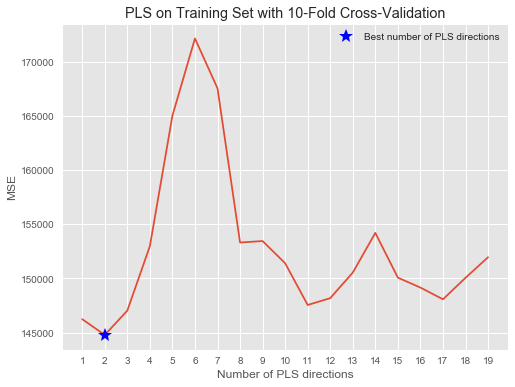

In [55]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
mse = []
for i in range(1, 20):
    pls = PLSRegression(n_components=i)
    scores = cross_val_score(pls, scale(X_train), y_train, cv=kf, scoring='neg_mean_squared_error')
    mse.append(scores.mean() * (-1))

# Find the number of PLS directions with lowest MSE, or highest CV score
min_mse = min(mse)
min_mse_idx = mse.index(min_mse) + 1

# Plot MSE vs. number of PLS directions
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1, 20), mse)
plt.xticks(range(20), range(20))
min_mse_marker, = plt.plot(min_mse_idx, min_mse, 'b*', markersize=15)
plt.xlabel('Number of PLS directions')
plt.ylabel('MSE')
plt.title('PLS on Training Set with 10-Fold Cross-Validation')
plt.legend([min_mse_marker], ['Best number of PLS directions'])
plt.show()

The lowest MSE occurs with 2 PLS directions, which is now used for evaluating on test set.

In [56]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

104711.20627773694